# Customer Churn Prediction

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

from bedrock_client.bedrock.analyzer.model_analyzer import ModelAnalyzer
from bedrock_client.bedrock.analyzer import ModelTypes

from utils import lgb_roc_auc_score, print_results, plot_pr_curve, plot_roc_curve

sns.set()
%matplotlib inline
%load_ext autoreload
%autoreload 2

## EDA - data deepdive

The first task in any data science or ML project is to understand and clean the data.

- Understand the data types for each feature
- Look for anomalies and missing values
- Understand the distributions for each feature

In [2]:
subscribers = pd.read_parquet('data/subscribers.gz.parquet', engine='fastparquet')
subscribers.head()

,User_id,State,Tenure,Area_Code,Phone,Intl_Plan,VMail_Plan,VMail_Message,CustServ_Calls,Churn
0,cfcd208495d565ef66e7dff9f98764da,KS,128,415,382-4657,no,yes,25,1,no
1,c4ca4238a0b923820dcc509a6f75849b,OH,107,415,371-7191,no,yes,26,1,no
2,c81e728d9d4c2f636f067f89cc14862c,NJ,137,415,358-1921,no,no,0,0,no
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,OH,84,408,375-9999,yes,no,0,2,no
4,a87ff679a2f3e71d9181a67b7542122c,OK,75,415,330-6626,yes,no,0,3,no


In [3]:
# Churn counts
subscribers["Churn"].value_counts()

no     2850
yes     483
Name: Churn, dtype: int64

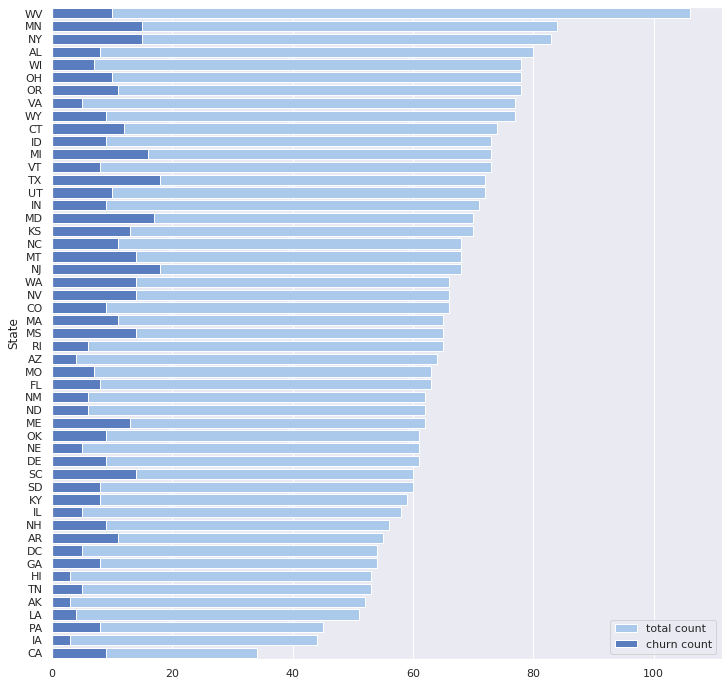

In [4]:
vcount = subscribers["State"].value_counts().reset_index()
vcount.columns = ["State", "Total"]

vcount2 = subscribers["State"].loc[subscribers["Churn"] == "yes"].value_counts().reset_index()
vcount2.columns = ["State", "Left"]

vcount = pd.merge(vcount, vcount2, on=["State"])
vcount = vcount.fillna(0)

plt.figure(figsize=(12, 12))
sns.set_color_codes("pastel")
sns.barplot(x="Total", y="State", data=vcount, color="b", label="total count")

sns.set_color_codes("muted")
sns.barplot(x="Left", y="State", data=vcount, color="b", label="churn count")
plt.xlabel("")
plt.legend()
plt.show()

In [5]:
all_calls = pd.read_parquet('data/all_calls.gz.parquet', engine='fastparquet')
all_calls.head()

,User_id,Duration,Call_type
0,6766aa2750c19aad2fa1b32f36ed4aee,1.451465,Day
1,8fe0093bb30d6f8c31474bd0764e6ac0,0.318914,Eve
2,0234c510bc6d908b28c70ff313743079,2.111892,Day
3,dba132f6ab6a3e3d17a8d59e82105f4c,3.305193,Eve
4,d542599794c1cf067d90638b5d3911f3,1.924791,Night


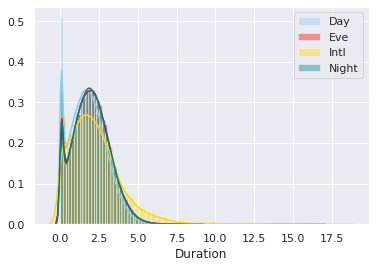

In [6]:
plt.figure()
sns.distplot(all_calls["Duration"].loc[all_calls["Call_type"] == "Day"],
             color="skyblue", label="Day")
sns.distplot(all_calls["Duration"].loc[all_calls["Call_type"] == "Eve"],
             color="red", label="Eve")
sns.distplot(all_calls["Duration"].loc[all_calls["Call_type"] == "Intl"],
             color="gold", label="Intl")
sns.distplot(all_calls["Duration"].loc[all_calls["Call_type"] == "Night"],
             color="teal", label="Night")
plt.legend()
plt.show()

## Feature engineering and Preprocessing

One can increase the predictive quality of the data using feature engineering.

- Feature crosses
- Embeddings
- PCA
- Categorical encoding

For example, we shall perform one-hot encoding on `Area_Code` and `State`.

```
Unique area codes =  [415 408 510]

Unique state codes = ['KS' 'OH' 'NJ' 'OK' 'AL' 'MA' 'MO' 'LA' 'WV' 'IN' 'RI' 'IA' 'MT' 'NY'
 'ID' 'VT' 'VA' 'TX' 'FL' 'CO' 'AZ' 'SC' 'NE' 'WY' 'HI' 'IL' 'NH' 'GA'
 'AK' 'MD' 'AR' 'WI' 'OR' 'MI' 'DE' 'UT' 'CA' 'MN' 'SD' 'NC' 'WA' 'NM'
 'NV' 'DC' 'KY' 'ME' 'MS' 'TN' 'PA' 'CT' 'ND']
```

In [7]:
# Subscribers data
subscribers = pd.read_parquet("data/subscribers.gz.parquet", engine="fastparquet")
for col in ["Churn", "Intl_Plan", "VMail_Plan"]:
    subscribers[col] = (subscribers[col] == "yes").astype(int)

# Calls data
all_calls = pd.read_parquet("data/all_calls.gz.parquet", engine="fastparquet")
all_calls = all_calls.groupby(["Call_type", "User_id"]).agg(["sum", "count"]).reset_index()
all_calls.columns = ["Call_type", "User_id", "Mins", "Calls"]
all_calls = all_calls.pivot(index="User_id", columns="Call_type", values=["Mins", "Calls"]).reset_index()
all_calls.columns = [
    "User_id", "Day_Mins", "Eve_Mins", "Intl_Mins", "Night_Mins",
    "Day_Calls", "Eve_Calls", "Intl_Calls", "Night_Calls"]

# Joining
model_data = pd.merge(subscribers, all_calls, on=["User_id"], how="left")
model_data = model_data.fillna(0)

# Categorical encoding
model_data = pd.get_dummies(model_data, columns=["Area_Code", "State"])

## Split train, validation and test data

In [8]:
FEATURE_COLS = [
    "Intl_Plan", "VMail_Plan", "VMail_Message", "CustServ_Calls",
    "Day_Mins", "Day_Calls", "Eve_Mins", "Eve_Calls", 
    "Night_Mins", "Night_Calls", "Intl_Mins", "Intl_Calls",
    "Area_Code_408", "Area_Code_415", "Area_Code_510",
    "State_AK", "State_AL", "State_AR", "State_AZ", "State_CA", "State_CO",
    "State_CT", "State_DC", "State_DE", "State_FL", "State_GA", "State_HI",
    "State_IA", "State_ID", "State_IL", "State_IN", "State_KS", "State_KY",
    "State_LA", "State_MA", "State_MD", "State_ME", "State_MI", "State_MN",
    "State_MO", "State_MS", "State_MT", "State_NC", "State_ND", "State_NE",
    "State_NH", "State_NJ", "State_NM", "State_NV", "State_NY", "State_OH",
    "State_OK", "State_OR", "State_PA", "State_RI", "State_SC", "State_SD",
    "State_TN", "State_TX", "State_UT", "State_VA", "State_VT", "State_WA",
    "State_WI", "State_WV", "State_WY",
]

TARGET_COL = "Churn"

In [9]:
train_data, eval_data, test_data = np.split(
    model_data.sample(frac=1, random_state=1729),
    [int(0.7 * len(model_data)), int(0.9 * len(model_data))])

X_train = train_data[FEATURE_COLS]
y_train = train_data[TARGET_COL]

X_val = eval_data[FEATURE_COLS]
y_val = eval_data[TARGET_COL]

X_test = test_data[FEATURE_COLS]
y_test = test_data[TARGET_COL]

In [11]:
test_data.to_csv("data/test.csv", index=False)

## Train model

We use **LightGBM**: a gradient boosting framework that uses tree based learning algorithms.

In [10]:
clf = lgb.LGBMClassifier(num_leaves=10, learning_rate=0.05, n_estimators=100)
clf.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric=lgb_roc_auc_score,
    verbose=False,
)

LGBMClassifier(learning_rate=0.05, num_leaves=10)

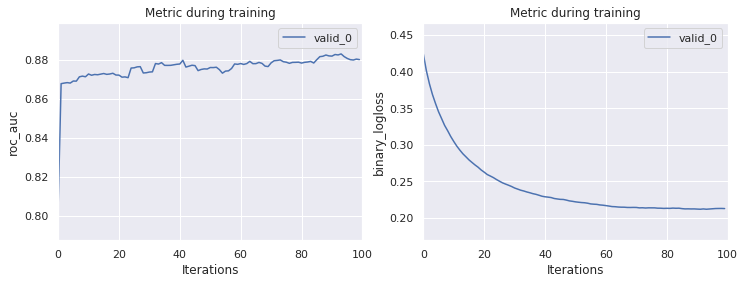

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
lgb.plot_metric(clf, "roc_auc", ax=axs[0])
lgb.plot_metric(clf, "binary_logloss", ax=axs[1])
plt.show()

## Evaluate using test set

In [12]:
y_probs = clf.predict_proba(X_test)[:,1]

print_results(y_test, y_probs)

Confusion matrix:
[[283   3]
 [ 11  37]] 

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       286
           1       0.93      0.77      0.84        48

    accuracy                           0.96       334
   macro avg       0.94      0.88      0.91       334
weighted avg       0.96      0.96      0.96       334



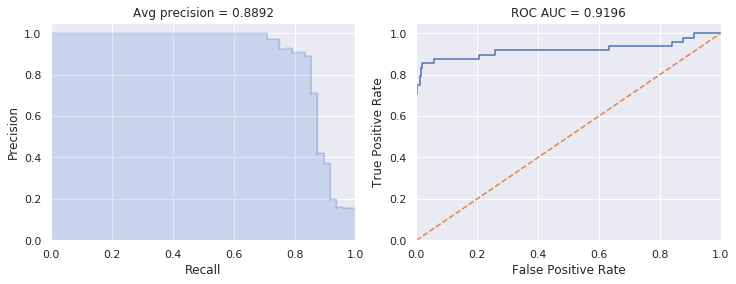

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
plot_pr_curve(y_test, y_probs, axs[0])
plot_roc_curve(y_test, y_probs, axs[1])
plt.show()

## Explainability using ModelAnalyzer

We shall use `bedrock_client.bedrock.analyzer.model_analyzer.ModelAnalyzer` to generate model explainability analysis locally. You can use it to generate and log them in Bedrock.

Refer to [documentation](https://docs.basis-ai.com/guides/explainability-and-fairness) and [API references](https://docs.basis-ai.com/guides/explainability-and-fairness/api-references) for more details.

In [15]:
analyzer = ModelAnalyzer(clf, "churn_prediction", model_type=ModelTypes.TREE)

# To set test data used for calculating explainability
analyzer.test_features(X_test)
analyzer.stored_sample_limit(sample_limit=None)  # To output all SHAP values for the test data

(shap_values, base_values, global_xai_data, fairness_metrics) = analyzer.analyze()

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


## Analyzer outputs

### SHAP values
Array of SHAP values calculated on provided `test_features`

In [17]:
shap_values

[array([[ 0.15419714, -0.04348571, -0.00862618, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.15260342,  0.16744947,  0.03276369, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.15149579,  0.14623928,  0.02765375, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.14821897, -0.06448763, -0.01022431, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.13996391,  0.10384648, -0.01747385, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.15095047, -0.0614824 , -0.00992499, ...,  0.        ,
          0.        ,  0.        ]]),
 array([[-0.15419714,  0.04348571,  0.00862618, ...,  0.        ,
          0.        ,  0.        ],
        [-0.15260342, -0.16744947, -0.03276369, ...,  0.        ,
          0.        ,  0.        ],
        [-0.15149579, -0.14623928, -0.02765375, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.14821897,  0.06448763,  0.01022431, ...,  0.        ,
          0.        ,  0.        ],
        [-0.13996391, -0.10384648,  0.01747385, ...,  0.        ,
          0.        ,  0.        ],
        [-0.15095047,  0.0614824 ,  0.00992499, ...,  0.        ,
          0.        ,  0.        ]])]

### Base value
Base value is the average model output calculated on background data

In [18]:
base_values

array([ 2.77583732, -2.77583732])

### Global XAI data
Global XAI returns the mean absolute shap values of each feature, together with its correlation with said feature

In [19]:
global_xai_data.keys()

dict_keys(['class 0', 'class 1'])


In [20]:
global_xai_data["class 1"]["Intl_Plan"]

{'mean_abs_shap': 0.3416984816536754, 'corrcoeff': -0.8558816398653132}

### Fairness metrics

Fairness metrics are empty since no fairness config was passed

In [20]:
fairness_metrics

## Optional: Plotting explainability

Using the compute SHAP values and `shap.summary_plot`, we can obtain a preliminary view of the effects of the top features.

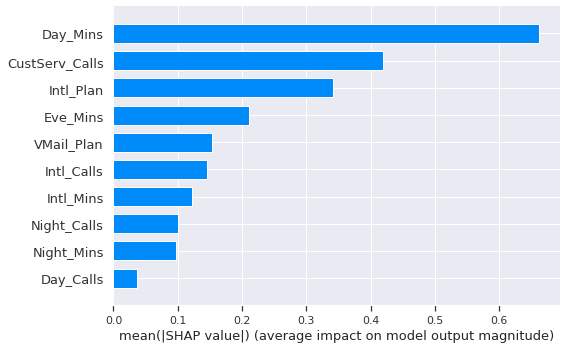

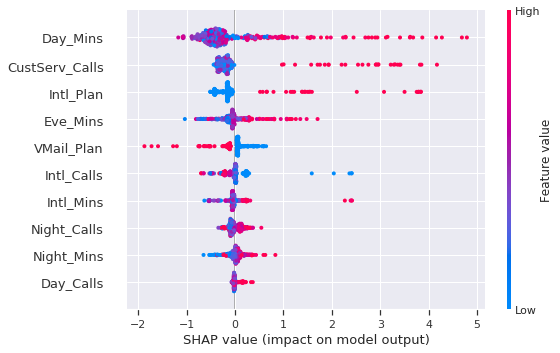

In [16]:
import shap

# We use the SHAP values that correspond to `Churn=1`, ie shap_values[1]
shap.summary_plot(shap_values[1], X_test, plot_type="bar", max_display=10)
shap.summary_plot(shap_values[1], X_test, max_display=10)